Identifying Age-Related Conditions

Team Members: Akhila Ganti, Megan Nguyen, Leslie Nie, Kevin Stallone, and Tim Tung
Github Repo: https://github.com/UC-Berkeley-I-School/mids-207-final-project-summer23-Tung-Ganti-Nie-Nguyen-Stallone.git

Project Description

The goal of this project is to predict if a person has any of three age-related medical conditions. To assess, we will create a model trained on measurements of health characteristics.

Motivation

"Aging is a risk factor for numerous diseases and complications. The growing field of bioinformatics includes research into interventions that can help slow and reverse biological aging and prevent major age-related ailments. Data science could have a role to play in developing new methods to solve problems with diverse data, even if the number of samples is small."

Data Source

Data is sourced from an active (June 2023) Kaggle competition: https://www.kaggle.com/competitions/icr-identify-age-related-conditions/overview

Step 1: Import Libraries

In [44]:
# standard libraries
import pandas as pd
import numpy as np
import random
import os


# tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
random.seed(2)

Dataset information as per Kaggle (https://www.kaggle.com/competitions/icr-identify-age-related-conditions/data)

train.csv - The training set. Id Unique identifier for each observation.
  AB-GL Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.
  Class A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.

test.csv - The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.

greeks.csv - Supplemental metadata, only available for the training set.

Alpha Identifies the type of age-related condition, if present.

A No age-related condition. Corresponds to class 0.

B, D, G The three age-related conditions. Correspond to class 1.

Beta, Gamma, Delta Three experimental characteristics.

Epsilon The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

Step 2: Import Data

In [2]:
greeks = pd.read_csv('/Users/akhilaganti/UCB_MIDS_w207/Final_Project/greeks.csv')
train = pd.read_csv('/Users/akhilaganti/UCB_MIDS_w207/Final_Project/train.csv')
test = pd.read_csv('/Users/akhilaganti/UCB_MIDS_w207/Final_Project/test.csv')

print('greeks data:', greeks.shape)
print('train data:', train.shape)
print('test data:', test.shape)



greeks data: (617, 6)
train data: (617, 58)
test data: (5, 57)


Step 3: EDA

In [3]:
greeks.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [4]:
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [5]:
test.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train.isna().sum()

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

In [41]:
features =[]
for col in train.columns:
    features.append(col)
    

#labels = ['class_label']
features

['Id',
 'AB',
 'AF',
 'AH',
 'AM',
 'AR',
 'AX',
 'AY',
 'AZ',
 'BC',
 'BD ',
 'BN',
 'BP',
 'BQ',
 'BR',
 'BZ',
 'CB',
 'CC',
 'CD ',
 'CF',
 'CH',
 'CL',
 'CR',
 'CS',
 'CU',
 'CW ',
 'DA',
 'DE',
 'DF',
 'DH',
 'DI',
 'DL',
 'DN',
 'DU',
 'DV',
 'DY',
 'EB',
 'EE',
 'EG',
 'EH',
 'EJ',
 'EL',
 'EP',
 'EU',
 'FC',
 'FD ',
 'FE',
 'FI',
 'FL',
 'FR',
 'FS',
 'GB',
 'GE',
 'GF',
 'GH',
 'GI',
 'GL',
 'Class']

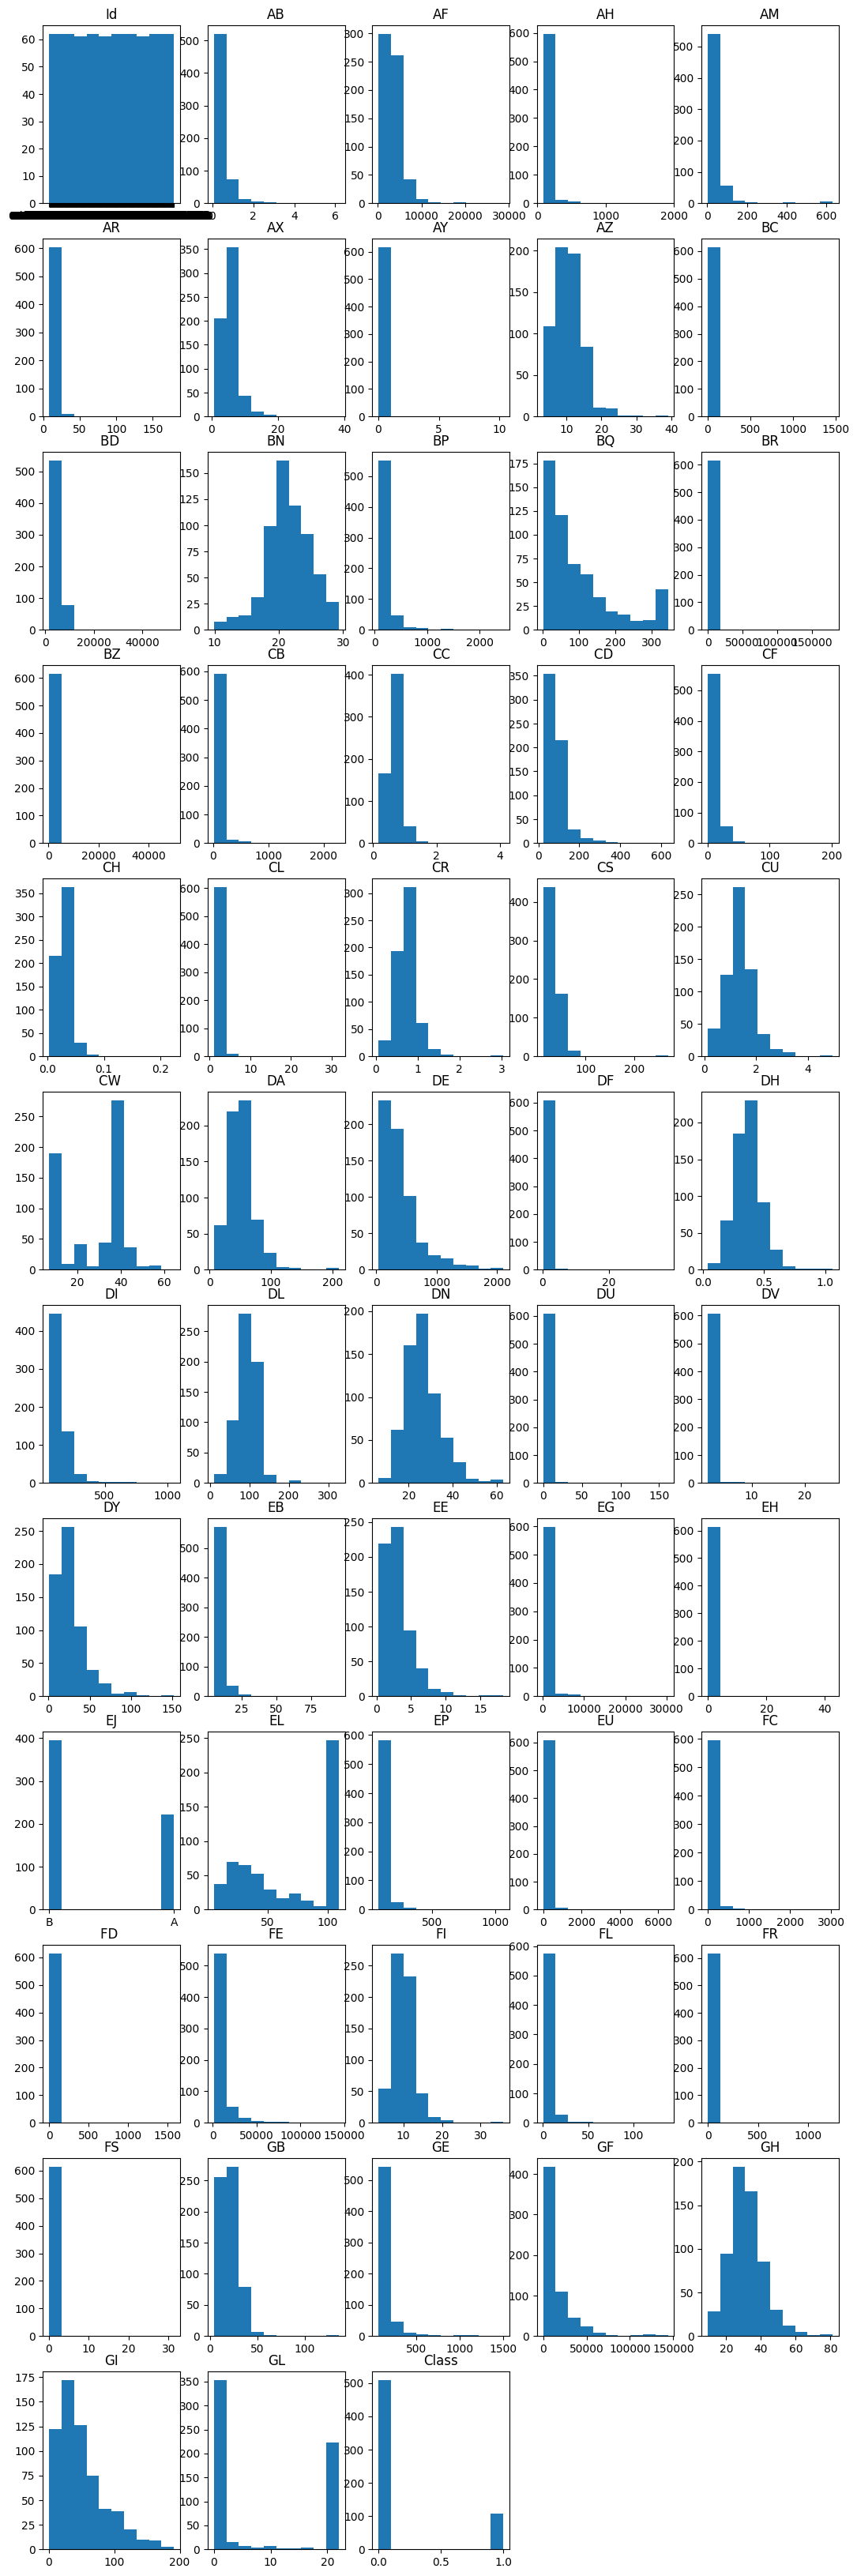

In [9]:
# Create a figure and set the figsize argument so we get square plots of the 57 features
    
plt.figure(figsize=(13, 45))

# Iterate over the features, creating a subplot with a histogram for each one.
for idx, feature in enumerate(features):
    plt.subplot(13, 5, idx+1)
    train[feature].hist(bins=10, grid=False)
    plt.title(feature)

In [37]:
# Select any rows in the training dataset that have null values in any feature

train[train.isna().any(axis=1)]

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
8,0594b00fb30a,0.346113,3238.43674,85.200147,28.888816,8.138688,4.021986,0.025578,8.243016,3.626448,...,4.762291,1.18262,0.067730,17.245908,147.218610,4589.611956,29.771721,54.675576,0.073416,0
15,07760b4cf3f8,0.666588,3657.78160,304.283751,75.418144,8.138688,12.818973,0.025578,8.167392,1.229900,...,67.872762,0.77720,0.582478,4.102182,72.611063,2218.449060,23.806958,35.843392,0.015231,0
18,0b2cc0b0e6c5,0.269199,1586.67784,85.200147,14.459893,8.138688,4.907886,0.032886,7.007824,3.521028,...,97.303580,2.73702,0.711165,16.362218,72.611063,3597.877440,31.330820,25.444796,0.011000,0
23,0cf6c827b8bb,0.371751,2354.54142,105.030540,5.150311,8.138688,10.409325,0.025578,11.526358,2.754976,...,4.648113,0.49706,0.866944,21.664358,198.469061,5987.708568,32.610844,15.019194,0.136552,0
24,0d1b855c7635,0.158101,3257.64549,138.368592,8.640630,18.385464,4.146012,0.182700,4.099451,7.836220,...,0.173229,1.82323,0.433472,8.311337,72.611063,1884.728169,48.039971,37.160256,21.978000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,f12d8570682a,0.282018,4226.17426,91.392246,13.704225,8.138688,4.916745,0.025578,9.415188,1.229900,...,4.874422,1.76204,0.386061,12.660022,72.611063,2118.717486,20.714807,29.786332,0.069164,0
594,f46e39a96ee9,0.670861,5501.73569,93.822057,6.993026,8.138688,6.511365,0.025578,9.541228,1.229900,...,NaN,0.49706,0.731484,37.310322,143.490662,1849.552461,31.371751,10.043660,NaN,0
602,f955c0ed8895,0.350386,5431.63797,85.200147,11.607556,8.138688,7.565586,0.025578,10.269109,2.393034,...,4.764967,0.49706,0.704392,12.027486,212.210348,9146.473587,17.287766,30.712252,0.171600,0
603,f96e7ca4a16c,0.662315,1704.39874,123.807144,68.353887,8.138688,5.563452,0.104139,6.736838,1.229900,...,5.781491,1.56600,0.067730,12.073996,72.611063,2369.417670,19.367805,25.591400,0.130680,0


In [38]:
train[train['BQ'].isna()]

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
8,0594b00fb30a,0.346113,3238.43674,85.200147,28.888816,8.138688,4.021986,0.025578,8.243016,3.626448,...,4.762291,1.18262,0.067730,17.245908,147.218610,4589.611956,29.771721,54.675576,0.073416,0
15,07760b4cf3f8,0.666588,3657.78160,304.283751,75.418144,8.138688,12.818973,0.025578,8.167392,1.229900,...,67.872762,0.77720,0.582478,4.102182,72.611063,2218.449060,23.806958,35.843392,0.015231,0
18,0b2cc0b0e6c5,0.269199,1586.67784,85.200147,14.459893,8.138688,4.907886,0.032886,7.007824,3.521028,...,97.303580,2.73702,0.711165,16.362218,72.611063,3597.877440,31.330820,25.444796,0.011000,0
23,0cf6c827b8bb,0.371751,2354.54142,105.030540,5.150311,8.138688,10.409325,0.025578,11.526358,2.754976,...,4.648113,0.49706,0.866944,21.664358,198.469061,5987.708568,32.610844,15.019194,0.136552,0
45,12d002d52230,1.491277,2434.32640,137.149332,124.242349,8.138688,4.730706,0.025578,4.487024,1.229900,...,9.126892,2.44238,0.067730,30.919848,72.611063,819.350802,20.156657,31.537864,0.027000,0
46,1319c3883fff,0.243561,3316.81570,85.200147,13.406913,8.138688,3.809370,0.025578,10.505434,4.258968,...,17.726310,0.99586,0.291239,14.585536,160.164837,6209.544726,36.942088,33.093924,0.051333,0
48,135f1d1da85e,0.820416,3594.95356,134.214399,54.129366,8.138688,7.565586,0.025578,6.428040,1.229900,...,4.192794,0.78474,0.209963,18.557490,118.296094,952.591590,29.634044,19.863556,0.078545,0
64,1899e6e0d7d9,0.512760,3756.02392,85.200147,25.674130,8.138688,7.973100,0.025578,7.310320,1.229900,...,4.932888,0.86014,0.711165,12.036788,72.611063,2418.052176,43.892916,33.003904,0.126465,0
71,1a6d2336590f,0.602493,5557.12344,100.797966,46.904065,8.138688,5.767209,0.025578,12.389732,9.347240,...,18.799615,0.49706,0.237055,26.733948,103.216456,642.540600,32.149440,39.436476,0.062526,0
119,2fd659800f75,0.405935,1011.87218,91.122267,69.840447,8.138688,6.573378,0.025578,7.398548,1.229900,...,4.336821,1.59732,0.392834,14.725066,72.611063,13055.309620,31.795945,29.781188,0.141429,0


In [39]:
train[train['EL'].isna()]

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
8,0594b00fb30a,0.346113,3238.43674,85.200147,28.888816,8.138688,4.021986,0.025578,8.243016,3.626448,...,4.762291,1.18262,0.067730,17.245908,147.218610,4589.611956,29.771721,54.675576,0.073416,0
15,07760b4cf3f8,0.666588,3657.78160,304.283751,75.418144,8.138688,12.818973,0.025578,8.167392,1.229900,...,67.872762,0.77720,0.582478,4.102182,72.611063,2218.449060,23.806958,35.843392,0.015231,0
18,0b2cc0b0e6c5,0.269199,1586.67784,85.200147,14.459893,8.138688,4.907886,0.032886,7.007824,3.521028,...,97.303580,2.73702,0.711165,16.362218,72.611063,3597.877440,31.330820,25.444796,0.011000,0
23,0cf6c827b8bb,0.371751,2354.54142,105.030540,5.150311,8.138688,10.409325,0.025578,11.526358,2.754976,...,4.648113,0.49706,0.866944,21.664358,198.469061,5987.708568,32.610844,15.019194,0.136552,0
45,12d002d52230,1.491277,2434.32640,137.149332,124.242349,8.138688,4.730706,0.025578,4.487024,1.229900,...,9.126892,2.44238,0.067730,30.919848,72.611063,819.350802,20.156657,31.537864,0.027000,0
46,1319c3883fff,0.243561,3316.81570,85.200147,13.406913,8.138688,3.809370,0.025578,10.505434,4.258968,...,17.726310,0.99586,0.291239,14.585536,160.164837,6209.544726,36.942088,33.093924,0.051333,0
48,135f1d1da85e,0.820416,3594.95356,134.214399,54.129366,8.138688,7.565586,0.025578,6.428040,1.229900,...,4.192794,0.78474,0.209963,18.557490,118.296094,952.591590,29.634044,19.863556,0.078545,0
64,1899e6e0d7d9,0.512760,3756.02392,85.200147,25.674130,8.138688,7.973100,0.025578,7.310320,1.229900,...,4.932888,0.86014,0.711165,12.036788,72.611063,2418.052176,43.892916,33.003904,0.126465,0
71,1a6d2336590f,0.602493,5557.12344,100.797966,46.904065,8.138688,5.767209,0.025578,12.389732,9.347240,...,18.799615,0.49706,0.237055,26.733948,103.216456,642.540600,32.149440,39.436476,0.062526,0
88,228524bde6a3,0.346113,4088.28992,85.200147,44.401689,8.138688,4.526949,0.025578,3.396778,1.229900,...,20.563808,0.78909,0.074503,42.454328,81.681372,2307.938913,35.077867,33.731780,0.028537,1


In [10]:
df = pd.merge(train, greeks, on='Id')

In [11]:
df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 63 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       617 non-null    object 
 1   AB       617 non-null    float64
 2   AF       617 non-null    float64
 3   AH       617 non-null    float64
 4   AM       617 non-null    float64
 5   AR       617 non-null    float64
 6   AX       617 non-null    float64
 7   AY       617 non-null    float64
 8   AZ       617 non-null    float64
 9   BC       617 non-null    float64
 10  BD       617 non-null    float64
 11  BN       617 non-null    float64
 12  BP       617 non-null    float64
 13  BQ       557 non-null    float64
 14  BR       617 non-null    float64
 15  BZ       617 non-null    float64
 16  CB       615 non-null    float64
 17  CC       614 non-null    float64
 18  CD       617 non-null    float64
 19  CF       617 non-null    float64
 20  CH       617 non-null    float64
 21  CL       617 non

In [15]:
df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [40]:
# Select any rows in the training dataset that have null values in any feature

df[df.isna().any(axis=1)]

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
8,0594b00fb30a,0.346113,3238.43674,85.200147,28.888816,8.138688,4.021986,0.025578,8.243016,3.626448,...,4589.611956,29.771721,54.675576,0.073416,0,A,C,M,B,2/18/2019
15,07760b4cf3f8,0.666588,3657.78160,304.283751,75.418144,8.138688,12.818973,0.025578,8.167392,1.229900,...,2218.449060,23.806958,35.843392,0.015231,0,A,C,M,B,1/29/2019
18,0b2cc0b0e6c5,0.269199,1586.67784,85.200147,14.459893,8.138688,4.907886,0.032886,7.007824,3.521028,...,3597.877440,31.330820,25.444796,0.011000,0,A,C,M,B,1/29/2019
23,0cf6c827b8bb,0.371751,2354.54142,105.030540,5.150311,8.138688,10.409325,0.025578,11.526358,2.754976,...,5987.708568,32.610844,15.019194,0.136552,0,A,C,M,B,Unknown
24,0d1b855c7635,0.158101,3257.64549,138.368592,8.640630,18.385464,4.146012,0.182700,4.099451,7.836220,...,1884.728169,48.039971,37.160256,21.978000,0,A,B,M,B,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,f12d8570682a,0.282018,4226.17426,91.392246,13.704225,8.138688,4.916745,0.025578,9.415188,1.229900,...,2118.717486,20.714807,29.786332,0.069164,0,A,C,M,B,2/18/2019
594,f46e39a96ee9,0.670861,5501.73569,93.822057,6.993026,8.138688,6.511365,0.025578,9.541228,1.229900,...,1849.552461,31.371751,10.043660,NaN,0,A,C,M,B,Unknown
602,f955c0ed8895,0.350386,5431.63797,85.200147,11.607556,8.138688,7.565586,0.025578,10.269109,2.393034,...,9146.473587,17.287766,30.712252,0.171600,0,A,C,M,B,11/27/2018
603,f96e7ca4a16c,0.662315,1704.39874,123.807144,68.353887,8.138688,5.563452,0.104139,6.736838,1.229900,...,2369.417670,19.367805,25.591400,0.130680,0,A,C,M,B,1/29/2019


A No age-related condition. Corresponds to class 0.

B, D, G The three age-related conditions. Correspond to class 1.

Of the 69 rows that have a null value in any feature, 6 are observations of disease conditions (4 B, 1 D, 1 G) and the balance are (A) healthy observations. At this time, maybe drop all observations that have any null values in any features, but may want to use a different approach given how few observations we have.

In [16]:
df.isna().sum()

Id         0
AB         0
AF         0
AH         0
AM         0
          ..
Alpha      0
Beta       0
Gamma      0
Delta      0
Epsilon    0
Length: 63, dtype: int64

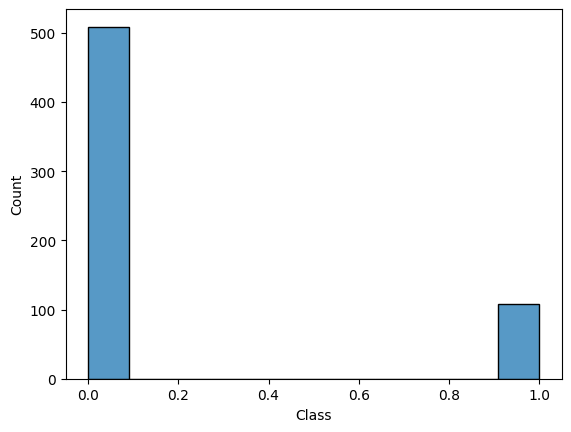

In [17]:
## Plot of Class data

fig, (ax0) = plt.subplots(1)

p0 = sns.histplot(
        data=train,
        stat='count',
        x='Class',
        ax=ax0
)

Looks like there is a class imbalance in the data.

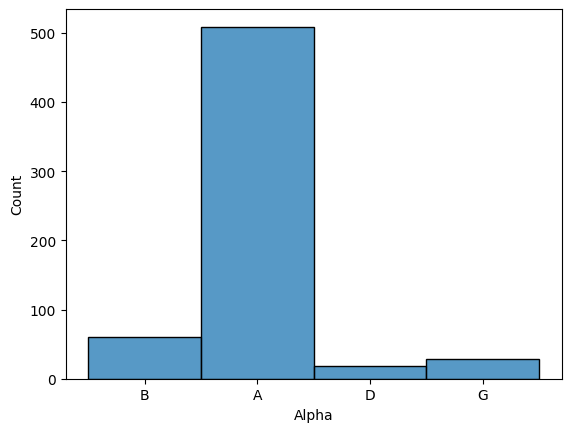

In [18]:
## Plot of Alpha data

fig, (ax1) = plt.subplots(1)

p1 = sns.histplot(
        data=greeks,
        stat='count',
        x='Alpha',
        ax=ax1
)


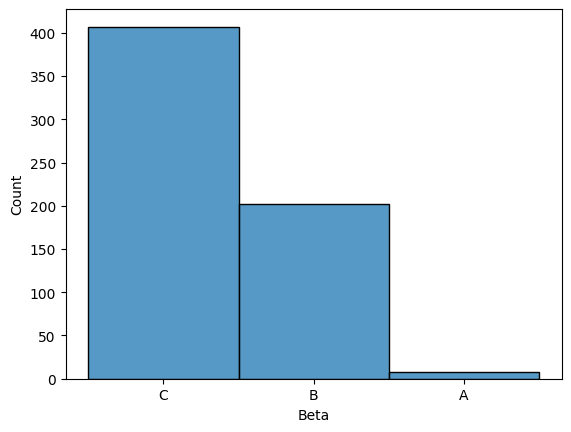

In [19]:
## Plot of Beta data

fig, (ax2) = plt.subplots(1)

p2 = sns.histplot(
        data=greeks,
        stat='count',
        x='Beta',
        ax=ax2
)

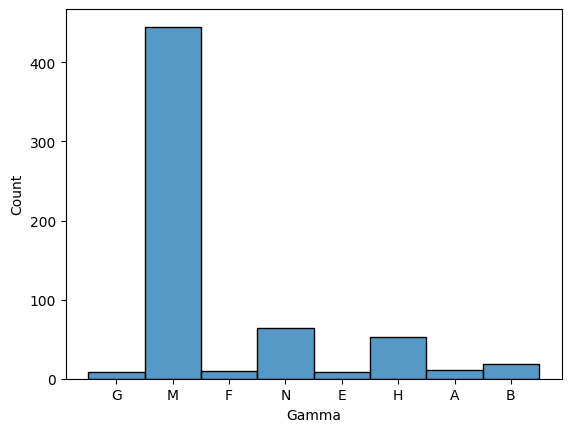

In [20]:
## Plot of Gamma data

fig, (ax3) = plt.subplots(1)

p3 = sns.histplot(
        data=greeks,
        stat='count',
        x='Gamma',
        ax=ax3
)

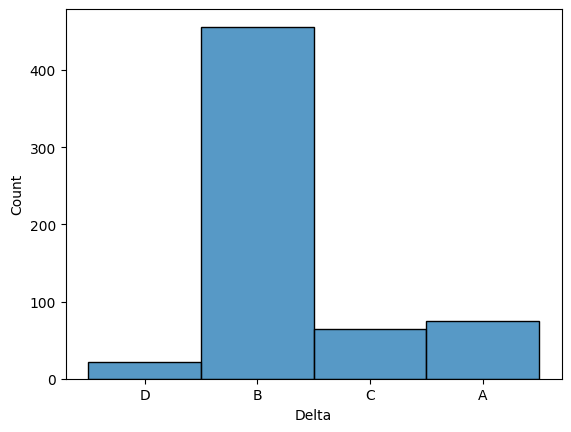

In [21]:
## Plot of Delta data

fig, (ax4) = plt.subplots(1)

p4 = sns.histplot(
        data=greeks,
        stat='count',
        x='Delta',
        ax=ax4
)

In [22]:
features1 =[]
for col in df.columns:
    features1.append(col)
    

#labels = ['class_label']
features1

['Id',
 'AB',
 'AF',
 'AH',
 'AM',
 'AR',
 'AX',
 'AY',
 'AZ',
 'BC',
 'BD ',
 'BN',
 'BP',
 'BQ',
 'BR',
 'BZ',
 'CB',
 'CC',
 'CD ',
 'CF',
 'CH',
 'CL',
 'CR',
 'CS',
 'CU',
 'CW ',
 'DA',
 'DE',
 'DF',
 'DH',
 'DI',
 'DL',
 'DN',
 'DU',
 'DV',
 'DY',
 'EB',
 'EE',
 'EG',
 'EH',
 'EJ',
 'EL',
 'EP',
 'EU',
 'FC',
 'FD ',
 'FE',
 'FI',
 'FL',
 'FR',
 'FS',
 'GB',
 'GE',
 'GF',
 'GH',
 'GI',
 'GL',
 'Class',
 'Alpha',
 'Beta',
 'Gamma',
 'Delta',
 'Epsilon']

In [23]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

In [24]:
# Temporarily drop the non-numeric features (EJ, Beta, Gamma, Delta) so that I can run correlations.
df_train_corr = df.drop(['Id','EJ','Alpha','Beta','Gamma','Delta','Epsilon'],axis=1)
df_train_corr

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,4517.86560,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


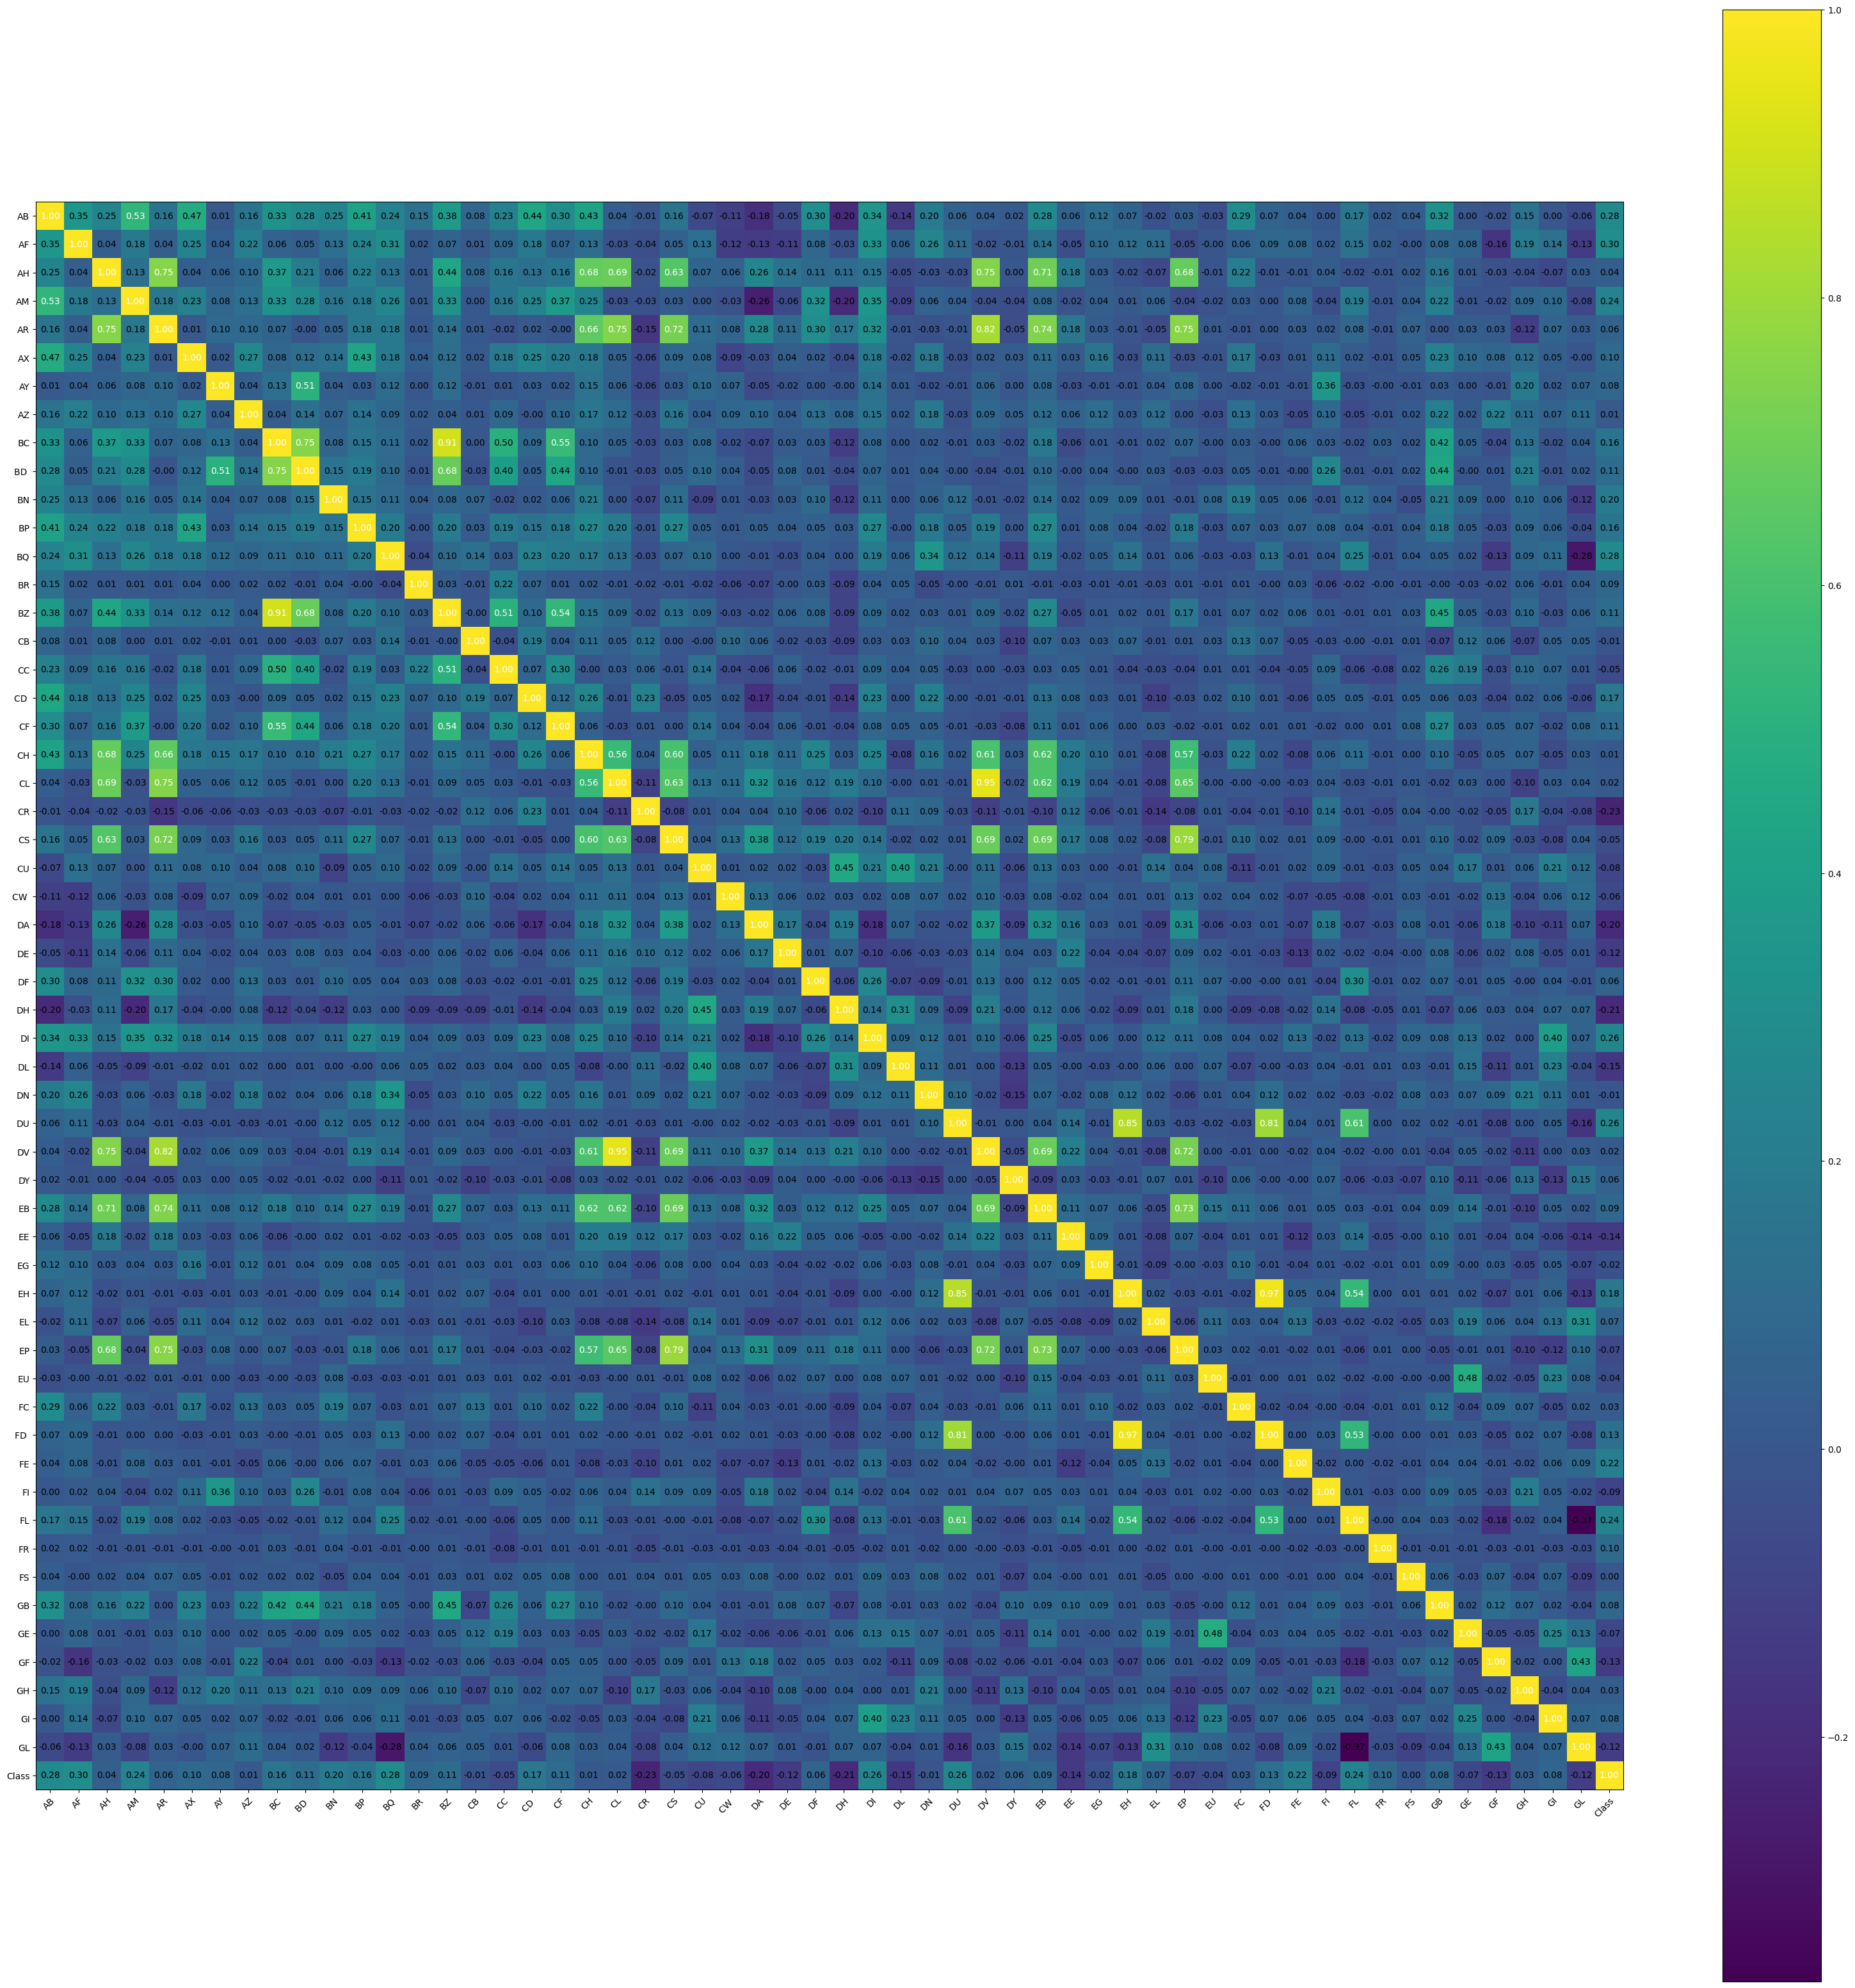

In [25]:
cm = df_train_corr.corr(numeric_only=True).values
hm = heatmap(
    cm,
    row_names=df_train_corr.columns,
    column_names=df_train_corr.columns,
    figsize=(40, 40)
)

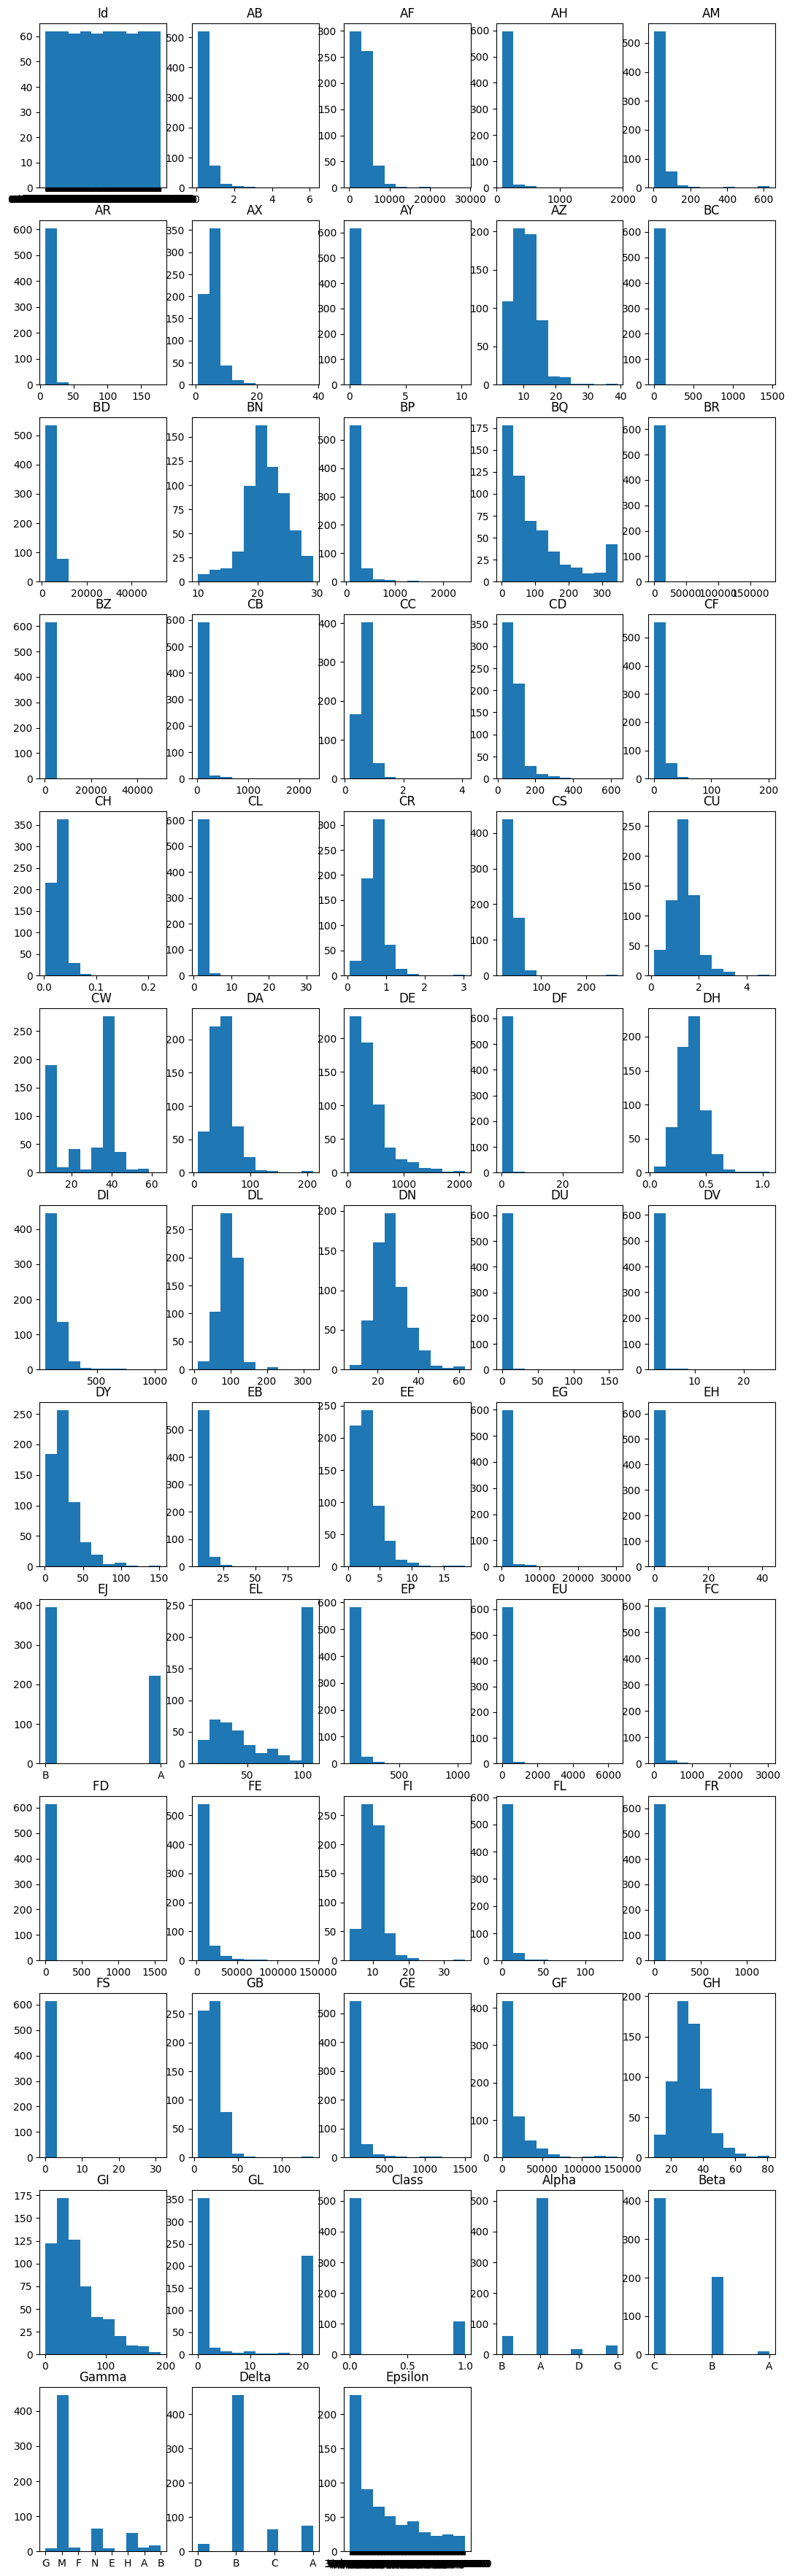

In [26]:
# Create a figure and set the figsize argument so we get square plots of the 57 features
    
plt.figure(figsize=(13, 45))

# Iterate over the features, creating a subplot with a histogram for each one.
for idx, feature in enumerate(features1):
    plt.subplot(13, 5, idx+1)
    df[feature].hist(bins=10, grid=False)
    plt.title(feature)

In [49]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df.Alpha))}
class_mapping

df['Alpha'] = df.Alpha.map(class_mapping) # notice how we use all 3 classes
labels = ['Alpha']
df

In [30]:
train['EJ'].replace(to_replace=['A', 'B'], value=[0, 1], inplace=True)
target_variable = train['Class']
features2 = train.drop(['Class', 'Id'],axis=1)

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
features2 = imputer.fit_transform(features2)

standarized_data = StandardScaler().fit_transform(features2)

tSNE to understand feature data variation

In [42]:
from sklearn.manifold import TSNE
model = TSNE(n_components=30, random_state=0,perplexity=50, n_iter=5000, method='exact')
TSNE_data = model.fit_transform(standarized_data)

In [34]:
print(TSNE_data.shape)

(617, 30)


In [36]:
TSNE_data

array([[ 1.0156088 ,  0.06629481,  0.5168931 , ...,  0.2910998 ,
         0.7188148 ,  0.01534844],
       [ 0.4395742 , -0.16807453,  1.0372633 , ...,  0.05077711,
         3.7318234 ,  0.8019856 ],
       [ 0.14590634, -1.285233  ,  0.42203525, ..., -0.04519523,
        -0.8034544 ,  0.20072693],
       ...,
       [-1.8979319 ,  0.9300835 ,  0.11249682, ...,  0.17024627,
        -0.4953196 ,  1.037628  ],
       [-0.01513745,  0.42664364, -0.16761039, ..., -0.47745076,
        -0.06760719,  0.04538047],
       [-0.04478477,  0.20212694,  0.88347465, ...,  0.03600588,
         0.93695384,  0.01493334]], dtype=float32)

PCA (Principal Component Analysis) for dimensionality reduction

Part 1: Standardize features in the original dataset

In [50]:
df2=df_train_corr
df2

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,4517.86560,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


In [60]:
df2.rename(columns = {'Class':'class_label'}, inplace = True)
# shift column 'class_label' to first position
first_column = df2.pop('class_label')
df2.insert(0, 'class_label', first_column)
df2

,class_label,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,1,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
1,0,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000
2,0,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941
3,0,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829
4,1,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,9.879296,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000
613,0,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.910227,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340
614,0,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,12.029366,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000
615,0,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,8.026928,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622


In [61]:
# create X and y numpy arrays
X, y = df2.iloc[:,1:].values, df2.iloc[:,0].values

# create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                   stratify=y, random_state=0)

# standardize the features (learn mean and variance from train data. Use these values to standardize both the train and test data!)
sc = StandardScaler()
sc.fit(X_train)
print("Mean: ", sc.mean_, '\nVariance: ', sc.var_)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Mean:  [4.68453650e-01 3.44529016e+03 1.17152094e+02 3.97158382e+01
 1.00280428e+01 5.44293055e+00 6.78173074e-02 1.04775063e+01
 9.62436497e+00 5.43701215e+03 2.14530780e+01 2.29973063e+02
 9.26075830e+01 1.38480213e+03 5.74121781e+02 7.32349057e+01
 6.94006153e-01 8.74738363e+01 1.12738407e+01 3.00429977e-02
 1.35242220e+00 7.36197303e-01 3.67255613e+01 1.37077609e+00
 2.71491018e+01 5.04752801e+01 3.75583434e+02 6.51853420e-01
 3.64899887e-01 1.44977951e+02 9.39889162e+01 2.59569127e+01
 1.59449337e+00 1.89332305e+00 2.63410463e+01 8.97745874e+00
 3.08884494e+00 1.63113367e+03 2.34918626e-01 7.17148653e+01
 1.03775789e+02 7.19950290e+01 6.92982093e+01 4.13071941e+00
 1.11094249e+04 1.00741761e+01 5.04672785e+00 1.54723343e+00
 4.33770578e-01 2.06387316e+01 1.26797287e+02 1.44353536e+04
 3.16851870e+01 5.09952320e+01 8.48259532e+00] 
Variance:  [1.84999031e-01 3.52619377e+06 1.42496897e+04 5.73042770e+03
 8.68569591e+01 4.81130655e+00 2.47027513e-01 1.89751280e+01
 6.03840017e+03 1.2

In [62]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,9.879296,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000
613,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.910227,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340
614,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,12.029366,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000
615,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,4517.86560,...,8.026928,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622


We have 55 features in the dataset, so we have 55 mean and variance values we use to standardize each feature.

Part 2: Construct the covariance matrix

In [63]:
cov_matrix = np.cov(X_train_std.T)
pd.DataFrame(cov_matrix)

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,1.002326,0.207278,0.272436,0.638641,0.238461,0.402533,0.014197,0.169649,0.422653,0.357899,...,-0.029051,NaN,0.032582,0.029240,0.429540,-0.018652,0.008377,0.068552,0.003726,NaN
1,0.207278,1.002326,0.056726,0.230040,0.095940,0.157777,0.064927,0.201666,0.073399,0.069971,...,0.012881,NaN,0.103756,0.001449,0.142025,0.077790,-0.180476,0.046084,0.183046,NaN
2,0.272436,0.056726,1.002326,0.180068,0.691518,0.050521,0.032489,0.103423,0.451953,0.288585,...,0.040760,NaN,-0.010743,0.014274,0.248285,0.030436,-0.021294,-0.011873,-0.051585,NaN
3,0.638641,0.230040,0.180068,1.002326,0.253566,0.269007,0.091271,0.147562,0.354654,0.316503,...,-0.013323,NaN,-0.017162,0.040860,0.287125,0.012153,-0.018013,0.073686,0.123727,NaN
4,0.238461,0.095940,0.691518,0.253566,1.002326,0.022744,0.088362,0.120935,0.074533,0.018044,...,0.002342,NaN,-0.006565,0.080313,0.039681,0.024527,0.034380,-0.087443,0.139994,NaN
5,0.402533,0.157777,0.050521,0.269007,0.022744,1.002326,0.028881,0.290985,0.106425,0.160495,...,0.111667,NaN,-0.000556,0.050248,0.280998,0.070673,0.108459,0.049594,0.041860,NaN
6,0.014197,0.064927,0.032489,0.091271,0.088362,0.028881,1.002326,0.047821,0.130816,0.527453,...,0.406205,NaN,0.008496,-0.011328,0.034797,0.003474,-0.005011,0.243667,0.031345,NaN
7,0.169649,0.201666,0.103423,0.147562,0.120935,0.290985,0.047821,1.002326,0.041077,0.145212,...,0.132141,NaN,-0.036593,0.016731,0.215742,0.040328,0.208087,0.099676,0.050850,NaN
8,0.422653,0.073399,0.451953,0.354654,0.074533,0.106425,0.130816,0.041077,1.002326,0.782809,...,0.034686,NaN,0.125233,0.017926,0.499819,0.071798,-0.048036,0.150493,-0.023377,NaN
9,0.357899,0.069971,0.288585,0.316503,0.018044,0.160495,0.527453,0.145212,0.782809,1.002326,...,0.287094,NaN,0.041305,0.008509,0.475103,0.015363,-0.001032,0.258599,-0.001679,NaN


Part 3: decompose the covariance matrix into eigenvectors and eigenvalues

In [56]:
eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)

In [57]:
print('Eigenvalues: ')
pd.DataFrame(eigen_values)

Eigenvalues: 


,0
0,1.002326
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


In [58]:
print('Eigenvectors :')
pd.DataFrame(eigen_vectors)

Eigenvectors :


,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Part 4: rank the eigenvalues by sorting them in decreasing order.

In [64]:
# compute the explained variance ratio
sum_eigen_values = sum(eigen_values)
print('Sum eigenvalues: ', sum_eigen_values)

expl_var_ratio = [i/sum_eigen_values for i in sorted(eigen_values, reverse=True)]
print('\nExplained variance ratio:')
pd.DataFrame(expl_var_ratio)

Sum eigenvalues:  nan

Explained variance ratio:


,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


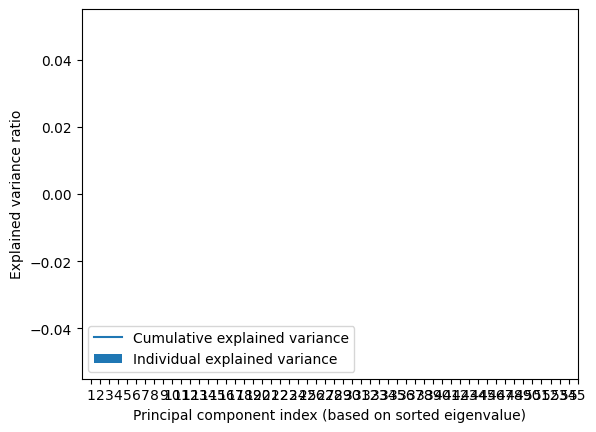

In [65]:
# visualize the explained variance ratio and the cumulative explained variance ratio
x_axis = range(1,len(eigen_values)+1)
y_axis = expl_var_ratio

# plot individual ratio
plt.bar(x_axis, y_axis, label='Individual explained variance')
# plot cumulative ratio
plt.step(x_axis, np.cumsum(y_axis), where='mid', label='Cumulative explained variance')

# legend, labels
plt.legend()
plt.xticks(x_axis)
plt.ylabel('Explained variance ratio');
plt.xlabel('Principal component index (based on sorted eigenvalue)');

Part 5: select  𝑘=2
  eigenvectors (based on the  𝑘=2
  largest eigenvalues)

In [66]:
# create eigen pairs of vectors and values
eigen_pairs = [(eigen_values[i], eigen_vectors[:,i]) for i in range(len(eigen_vectors))]

# transform to df
eigen_pairs = pd.DataFrame(eigen_pairs)
eigen_pairs.rename(columns={0: 'eigen_value', 1: 'eigen_vector'}, inplace=True)
eigen_pairs.head()

,eigen_value,eigen_vector
0,1.002326,"[1.0, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,NaN,"[0.0, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,NaN,"[0.0, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,NaN,"[0.0, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,NaN,"[0.0, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [67]:
# select the top 2 eigenvectors based on the eigenvalue
top2_eigen_vectors = eigen_pairs.nlargest(2, 'eigen_value')['eigen_vector'].values.tolist()
top2_eigen_vectors

[array([ 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan]),
 array([ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan])]

Part 6: construct the projection matrix,  𝐖
 , using the top  𝑘=2
  eigenvectors.

In [68]:
w = np.hstack((top2_eigen_vectors[0][:, np.newaxis],
               top2_eigen_vectors[1][:, np.newaxis],
               #top2_eigen_vectors[2][:, np.newaxis]
              ))
print('Matrix W:\n', w)
print('\nSize of Matrix W: ', w.shape)

Matrix W:
 [[ 1.  0.]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]

Size of Matrix W:  (55, 2)


Part 7: transform the original input dataset,  𝐗
 , using the projection matrix,  𝐖
 ,
to obtain the new  𝑘
 -dimensional feature subspace:  𝐗𝐖=𝐳

In [69]:
# training data
X_train_pca = X_train_std.dot(w)
pd.DataFrame(X_train_pca).head()

,0,1
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [70]:
# test data
X_test_pca = X_test_std.dot(w)
pd.DataFrame(X_test_pca).head()

,0,1
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


Let's visualize the new PCA 2-D features in the train wine dataset,

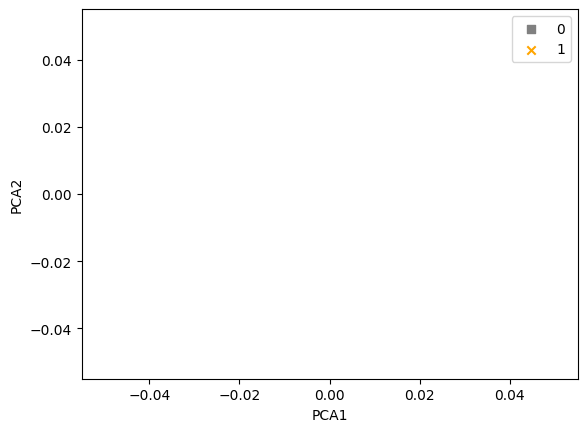

In [71]:
colors = ['grey', 'orange', 'blue']
markers = ['s', 'x', 'o']

# plot
for class_value, color, marker in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==class_value, 0],
                X_train_pca[y_train==class_value, 1],
                color = color, label = class_value, marker=marker)
    
# legend, axes
plt.legend(loc='best')
plt.xlabel('PCA1')
plt.ylabel('PCA2');

Let's now see PCA implemented in scikit-learn. The idea is to:

fit the data using the original X_train_std data
transform both X_train_std and X_test_std data using the same PCA parameters

In [72]:
# create an instance of the PCA class
pca = PCA(n_components=2)

# fit the data using the original X_train_std data; tranform X_train_std data
X_train_pca_skl = pca.fit_transform(X_train_std)

# transform the X_test_std data
X_test_pca_skl = pca.transform(X_test_std)

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
print('X_train_pca: our implementation\n')
pd.DataFrame(X_train_pca).head()

In [ ]:
print('X_train_pca: sklearn implementation\n')
pd.DataFrame(X_train_pca_skl).head()

In [ ]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(X_train_std, y_train)
print("Logistic regression score using standardized test data:", lm.score(X_test_std, y_test))

In [ ]:
lm = LogisticRegression()
lm.fit(X_train_pca, y_train)
print("Logistic regression score using test pca data:", lm.score(X_test_pca, y_test))